In [7]:
import os, sys
## add helpers to python path
if os.path.join('..','helpers') not in sys.path:
    sys.path.append(os.path.join('..','helpers'))

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import requests
import re
from io import BytesIO
from PIL import Image, ImageFilter
import object_mask_utils as u
import socket
import glob

from skimage import io, img_as_float
import base64

from IPython.core.pylabtools import figsize, getfigs

from IPython.display import clear_output
import importlib
import time

from collections import Counter
import operator

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### set up paths

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'data')
csv_dir = os.path.join(results_dir,'diagnosticity')
sketch_dir = os.path.abspath(os.path.join(csv_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(csv_dir,'gallery'))
map_dir = os.path.abspath(os.path.join(csv_dir,'maps'))
mask_dir = os.path.join(csv_dir, 'object_masks')


## import dictionaries that map between shapenet ids and graphical conventions naming scheme
importlib.reload(u)
G2S = u.GC2SHAPENET
S2G = u.SHAPENET2GC

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

def clear_dir(path_to_dir, ext = 'png'):
    files = glob.glob(os.path.join(path_to_dir, '*'))
    if len(files) > 0:
        for f in files:
            if f.split('.')[-1]==ext:
                os.remove(f)
        print('Deleted {} {} files in {}'.format(ext, len(files), path_to_dir))
    else:
        print('{} already empty. Did not delete any files.'.format(path_to_dir))
    return path_to_dir

## create directories that don't already exist        
result = [make_dir_if_not_exists(i) for i in [results_dir,csv_dir,sketch_dir,gallery_dir, map_dir, mask_dir]]

# Get object masks

People often annotated outside the boundaries of the actual object, so we use a segmentation mask

In [8]:
from objects import *

## convert dict to list
object_list = [shapenet_30afd2ef2ed30238aa3d0a2f00b54836,shapenet_30dc9d9cfbc01e19950c1f85d919ebc2,shapenet_4c1777173111f2e380a88936375f2ef4,
shapenet_3466b6ecd040e252c215f685ba622927,shapenet_38f87e02e850d3bd1d5ccc40b510e4bd,shapenet_3cf6db91f872d26c222659d33fd79709,
shapenet_3d7ebe5de86294b3f6bcd046624c43c9,shapenet_56262eebe592b085d319c38340319ae4,shapenet_1d1641362ad5a34ac3bd24f986301745,shapenet_1da9942b2ab7082b2ba1fdc12ecb5c9e,shapenet_2448d9aeda5bb9b0f4b6538438a0b930,
shapenet_23b0da45f23e5fb4f4b6538438a0b930,shapenet_2b5953c986dd08f2f91663a74ccd2338,shapenet_2e291f35746e94fa62762c7262e78952,
shapenet_2eaab78d6e4c4f2d7b0c85d2effc7e09,shapenet_309674bdec2d24d7597976c675750537]

## convert list of dicts to pd dataframe
O = pd.DataFrame(object_list)

this_url = O.url.values[0]

for i,d in O.iterrows():

    ## get image data from URL
    response = requests.get(d['url'])
    img = Image.open(BytesIO(response.content)).convert('RGB')

    ## find zero pixels and convert to object mask
    nonzeros = np.array(img)!=0
    _mask = nonzeros.astype(np.uint8).mean(2)*255
    mask = Image.fromarray(_mask).convert('L')

    ## save out mask to mask_dir
    fname = d['subordinate'] + '-mask.png'
    out_path = os.path.join(mask_dir, fname)
    mask.save(out_path) 
    print('{} | Saved out mask for {}!'.format(i+1, d['subordinate']))
    clear_output(wait=True)

print('Done!')

Done!


### load in annotations dataframe

If you haven't already run the `generate_dataframe.py` scripy locally, do so. Once you're on nightingale, run it again to make sure that the annotations are copied to the data dir.

In [5]:
## load in data
T = pd.read_csv(os.path.join(csv_dir,'semantic_mapping_annotations_stroke.csv'),
               usecols=['paintCanvasPng','svgString', 'condition','repetition','gameID','targetID', 'annotatorID','wID'])

## add sketch_id column
T = (T.assign(sketch_id = T.apply(lambda x: 
    '{}_{}_{}'.format(x['gameID'], x['targetID'], str(x['repetition']).zfill(2)),axis=1)))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/roberthawkins/Repos/graphical_conventions/data/diagnosticity/semantic_mapping_annotations_stroke.csv'

In [111]:
## invalid/blocked workerIDs who scribbled
invalid_workers = (['A1GKV6YWBQ8VU2', 'AFER5ZUTHAA5M', 'A19KUUI9FWPER6'] + ['A52B9HB6G1FYG', 'A2V290GUKCNFSX'] +
                   ['ADYFSE3TOTPLK', 'A1SPEUF3LGOF5M', 'A3NH7YCJLJX082', 'A26T013OSL4VI2', 'A2TZ71UUY1HGH3'] + 
                   ['A3739TTTJN07Z1', 'AMFQAV2CMCQMA', 'A1T3QUEIJ36AO6', 'A18T7E73TNGOKP', 'A2SWFKGQWUXU5N'] +
                   ['A2UHVW63V1CMD1', 'AKJ0CNE25NWIQ', 'A2NILISO17LNTJ', 'A2R20ADYVQD4X', 'AFV9LYFT59I2C'] + 
                   ['A33QMMCDIGGVAE', 'A3NF12KB859RHP', 'A29YJJRBSB7D8I', 'A2B1ER0536RFHF', 'ADS9U0CVXT2IE'] + 
                   ['A4M35GKK07AAS', 'A1OJZLO9E8Y0VB', 'A1LBXBV4KZ952A', 'A1ZHU7I53TTA5B', 'AHJJUX96EATA7']+
                   ['A2S3MMTULJT6R4', 'A1V4ASA56A0WHR'])


## single invalid sketch annotations
# invalid_sketchIDs = ['7741-1061961c-2778-483e-97de-15fc47b71ca5_waiting_07_07']

In [112]:
## show me invalid worker stats
showMeInvalids = False
if showMeInvalids:
    cumulative_invalid_sketches = 0
    for i,this_workerID in enumerate(invalid_workers):
        ## what else has this worker annotated?
        this_workers_annotations = T[(T['wID']==this_workerID)]['sketch_id'].unique()
        cumulative_invalid_sketches += len(this_workers_annotations)
        print(' {} | {} | This person annotated {} sketches.'.format(str(i+1).zfill(2), this_workerID, len(this_workers_annotations)))
    print('In total, they contributed {} invalid sketch annotations.'.format(cumulative_invalid_sketches))

In [113]:
## filter out invalids
T = T[~T['wID'].isin(invalid_workers)]
# T = T[~T['sketch_id'].isin(invalid_sketchIDs)]

print('There are {} records in T.'.format(T.shape[0]))    
print('These came from {} different refgames.'.format(T.gameID.nunique()))
print('These came from {} different annotation assignments.'.format(T.annotatorID.nunique()))
print('These came from {} different worker IDs.'.format(T.wID.nunique()))
print('{} of these came are from the repeated condition.'.format(T[T['condition']=='repeated'].shape[0]))
print('{} of these came are from the control condition.'.format(T[T['condition']=='control'].shape[0]))
print(T.info(verbose=False,memory_usage='deep'))

There are 22755 records in T.
These came from 65 different refgames.
These came from 311 different annotation assignments.
These came from 278 different worker IDs.
18056 of these came are from the repeated condition.
4699 of these came are from the control condition.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22755 entries, 0 to 32950
Columns: 9 entries, annotatorID to sketch_id
dtypes: int64(1), object(8)
memory usage: 122.7 MB
None


### manually check for invalid annotations

look at sketch map renderings to detect irregularities & scribbles

In [95]:
## which potentially problematic workerID?
this_workerID = 'A1V4ASA56A0WHR'

showThis = True
if showThis:
    ## what else has this worker annotated?
    this_workers_annotations = T[(T['wID']==this_workerID)]['sketch_id'].unique()
    print('This person annotated {} sketches.'.format(len(this_workers_annotations)))
    print(sorted(this_workers_annotations))
    for this_sketchID in sorted(this_workers_annotations):
        display(Image.open(os.path.join(sketch_dir, '{}.png'.format(this_sketchID))))
        display(Image.open(os.path.join(single_sketch_map_dir, '{}.png'.format(this_sketchID))))

This person annotated 0 sketches.
[]


### divide CSV data into batches to ease image processing

In [114]:
importlib.reload(u)

## divide CSV data into batches to ease image processing
sketch_ids = T.sketch_id.unique()
for i,curr_batch in enumerate(u.batch(sketch_ids, 50)):
    t = T[T['sketch_id'].isin(curr_batch)]
    out_path = os.path.join(datavol_dir,'semantic_mapping_annotations_stroke_batch{}.csv'.format(i))
    t.to_csv(out_path)
    print('Saved batch to {}'.format(out_path))
    clear_output(wait=True)
print('Done! Saved {} batches in total.'.format(i+1))

Done! Saved 52 batches in total.


In [97]:
##h = plt.hist(T2['responseLatency'].values,bins=100)

### now iterate through batches of dataset and apply image processing

In [115]:
def preprocess (T_batch) :
    start = time.time()

    ## apply preprocessing to get base heatmaps
    ims = T_batch.apply(lambda x: Image.open(BytesIO(base64.b64decode(x['paintCanvasPng']))), axis=1)
#     print('Finished converting png strings to PIL Images. {} seconds elapsed.'.format((time.time() - start)))        
    T_batch = T_batch.assign(imsb = ims.apply(lambda x: x.convert('RGB')))
#     print('Finished converting to RGB. {} seconds elapsed.'.format(np.round(time.time() - start,3)))            
    T_batch = T_batch.assign(arrs = T_batch['imsb'].apply(lambda x: np.array(x).astype(np.uint16)))
#     print('Finished adding image arrays to big dataframe. {} seconds elapsed.'.format(time.time() - start))
    
    # Filter out invalid imsizes & empty rows
    T_batch = T_batch.assign(valid_imsize = T_batch.apply(lambda x: True if x['arrs'].shape[0]==300 else False, axis=1))    
    T_batch = T_batch.assign(empty_annotation = T_batch.apply(lambda x: x['arrs'].flatten().sum() == 0, axis=1))    
    T_batch = T_batch[T_batch['valid_imsize'] == True]
    T_batch = T_batch[T_batch['empty_annotation'] != True]
    
    ## add identifier for (target, rep) combinations
    T_batch = T_batch.assign(target_rep = T_batch.apply(lambda x: '{}_{}'.format(x['targetID'], str(x['repetition']).zfill(2)), axis=1))
#     print('Finished filtering for valid images.')
    end = time.time()
#     print('{} seconds elapsed for image preprocessing.'.format(np.round(end-start,3)))
    return T_batch

In [116]:
## create dirs that do not already exist
single_sketch_map_dir = os.path.join(map_dir,'single_sketch_maps')
targetRep_sketch_map_dir = os.path.join(map_dir,'targetRep_sketch_maps')
result = [make_dir_if_not_exists(i) for i in [single_sketch_map_dir, targetRep_sketch_map_dir]]

## clear single sketch map dir
folder = clear_dir(single_sketch_map_dir)

Deleted png 2599 files in /home/jefan/semantic_mapping/results/maps/single_sketch_maps


In [155]:
### load in chunks of dataframe at a time to do all preprocessing
data_dir = datavol_dir if socket.gethostname()=='nightingale' else csv_dir
batch_paths = [os.path.join(data_dir,i) for i in os.listdir(data_dir) if i.split('_')[-1][:5]=='batch']


K = 11
for N in np.arange(10,K):
    A = dict()
    for batch_ind, path in enumerate(batch_paths):
        T_batch = preprocess(pd.read_csv(path))

        ## create H dictionary for each target and repetition for EACH REFGAME PARTICIPANT
        H = dict()
        for name, group in T_batch.groupby(['target_rep','gameID']):
            ## subset group to only include single annotation session?
            if len(group['annotatorID'].unique()) > 1:
                _arr = group['annotatorID'].unique() ## get unique annotation assignment ID's
                arr = _arr[~pd.isnull(_arr)] ## remove nans

                ## get annotatorID with the most records                
                thorough_annotatorID = max(Counter(group['annotatorID']).items(), key=operator.itemgetter(1))[0] 
                group_subset = group[group['annotatorID']==thorough_annotatorID]  
            else:
                group_subset = group

            ## exploratory: subset to first N/K fraction of strokes 
            ## question: how does diagnosticity change as function of cumulative amount of sketch completed?                
            num_early_strokes_included = np.int(np.ceil(N*group_subset.shape[0]/K))
            group_subset = group_subset[:num_early_strokes_included]
            single_subsketch_map_dir = os.path.join(map_dir,'single_subsketch_maps_{}_{}'.format(N,K))
            make_dir_if_not_exists(single_subsketch_map_dir)


            ## init dictionary     
            if not name[0] in H.keys():
                H[name[0]] = dict()

            ## stack arrays to form a single composite image, taking max value over any spatial position
            combined = np.amax(np.stack(np.array(group_subset['arrs']),axis=3), axis=3)
            
            ## load in object mask and cross with sketch map
            targetID = '_'.join(name[0].split('_')[:2])
            mask_path = os.path.join(mask_dir, '{}-mask.png'.format(targetID))
            object_mask = Image.open(mask_path).resize((300,300),Image.LANCZOS)            
            combined_masked = combined.astype(np.float32).mean(2) * object_mask / 255
            
            ## convert to binary PIL image and store in dictionary H 
            H[name[0]][name[1]] = (Image.fromarray(u.binarize_vec((u.minmaxnorm(combined_masked) * 255))
                                      .astype(np.uint8))
                                      .convert('1'))                              
            # record num annotations per sketch
            A['{}_{}'.format(name[1], name[0])] =  len(np.unique(group_subset['annotatorID'].values))
            # save image out as PNG to main single sketch map dir
            out_path = os.path.join(single_sketch_map_dir,'{}_{}.png'.format(name[1],name[0]))
            H[name[0]][name[1]].save(out_path)
            # also save out to another path, in subsketch map dir
            out_path_N_K = os.path.join(single_subsketch_map_dir,'{}_{}.png'.format(name[1],name[0]))
            H[name[0]][name[1]].save(out_path_N_K)        

            print('{}/{} | batch {} of {} | Saved out PNG for {} from {}'.format(N,K,batch_ind, len(batch_paths), name[0], name[1]))       
            clear_output(wait=True)

print('Done!')

Done!


In [9]:
(Image.fromarray(u.binarize_vec((u.minmaxnorm(x) * 255))
                                      .astype(np.uint8))
                                      .convert('1')) 

NameError: name 'x' is not defined

In [72]:
# ## see how many sketches have been annotated how many times
# from collections import Counter
# Counter(A.values())

### now get average heatmap, collapsing over annotators within a target/repetition combination


In [73]:
K = 10
for N in np.arange(1,K):

    S = [os.path.join(map_dir,'single_subsketch_maps_{}_{}'.format(N,K),i) for i in os.listdir(single_sketch_map_dir)]
    assert len(np.unique(['_'.join(i.split('_')[-3:]) for i in S])) == 16*8
    target_reps = np.unique(['_'.join(i.split('_')[-3:]).split('.')[0] for i in S])
    G = dict()

    for tr,this_targ in enumerate(target_reps):
        G[this_targ] = dict()    
        matches = [i for i in S if '_'.join(i.split('_')[-3:])==this_targ+'.png']
        avg = np.mean(np.array([np.array(Image.open(match)) for match in matches]), axis=0) * 255
        G[this_targ]['target'] = '_'.join(this_targ.split('_')[:2])
        G[this_targ]['layers'] = len(matches)
        im = (Image.fromarray(avg.astype(np.uint16))
                                          .convert('L'))
        # save image out as PNG
        out_dir = os.path.join(map_dir, 'targetRep_subsketch_maps_{}_{}'.format(N,K))
        make_dir_if_not_exists(out_dir)
        out_path = os.path.join(out_dir,'{}.png'.format(this_targ))

        im.save(out_path)
        print('{} of {} |Saved out PNG for {}'.format(tr,len(target_reps),this_targ))
        clear_output(wait=True)
    
# save out metadata    
out_path = os.path.join(map_dir,'targetRep_map_meta.js')
with open(out_path, 'w') as fout:
    json.dump(G, fout)    
print('Done!')

Done!


Done saving gallery figure to /home/jefan/semantic_mapping/results/gallery!


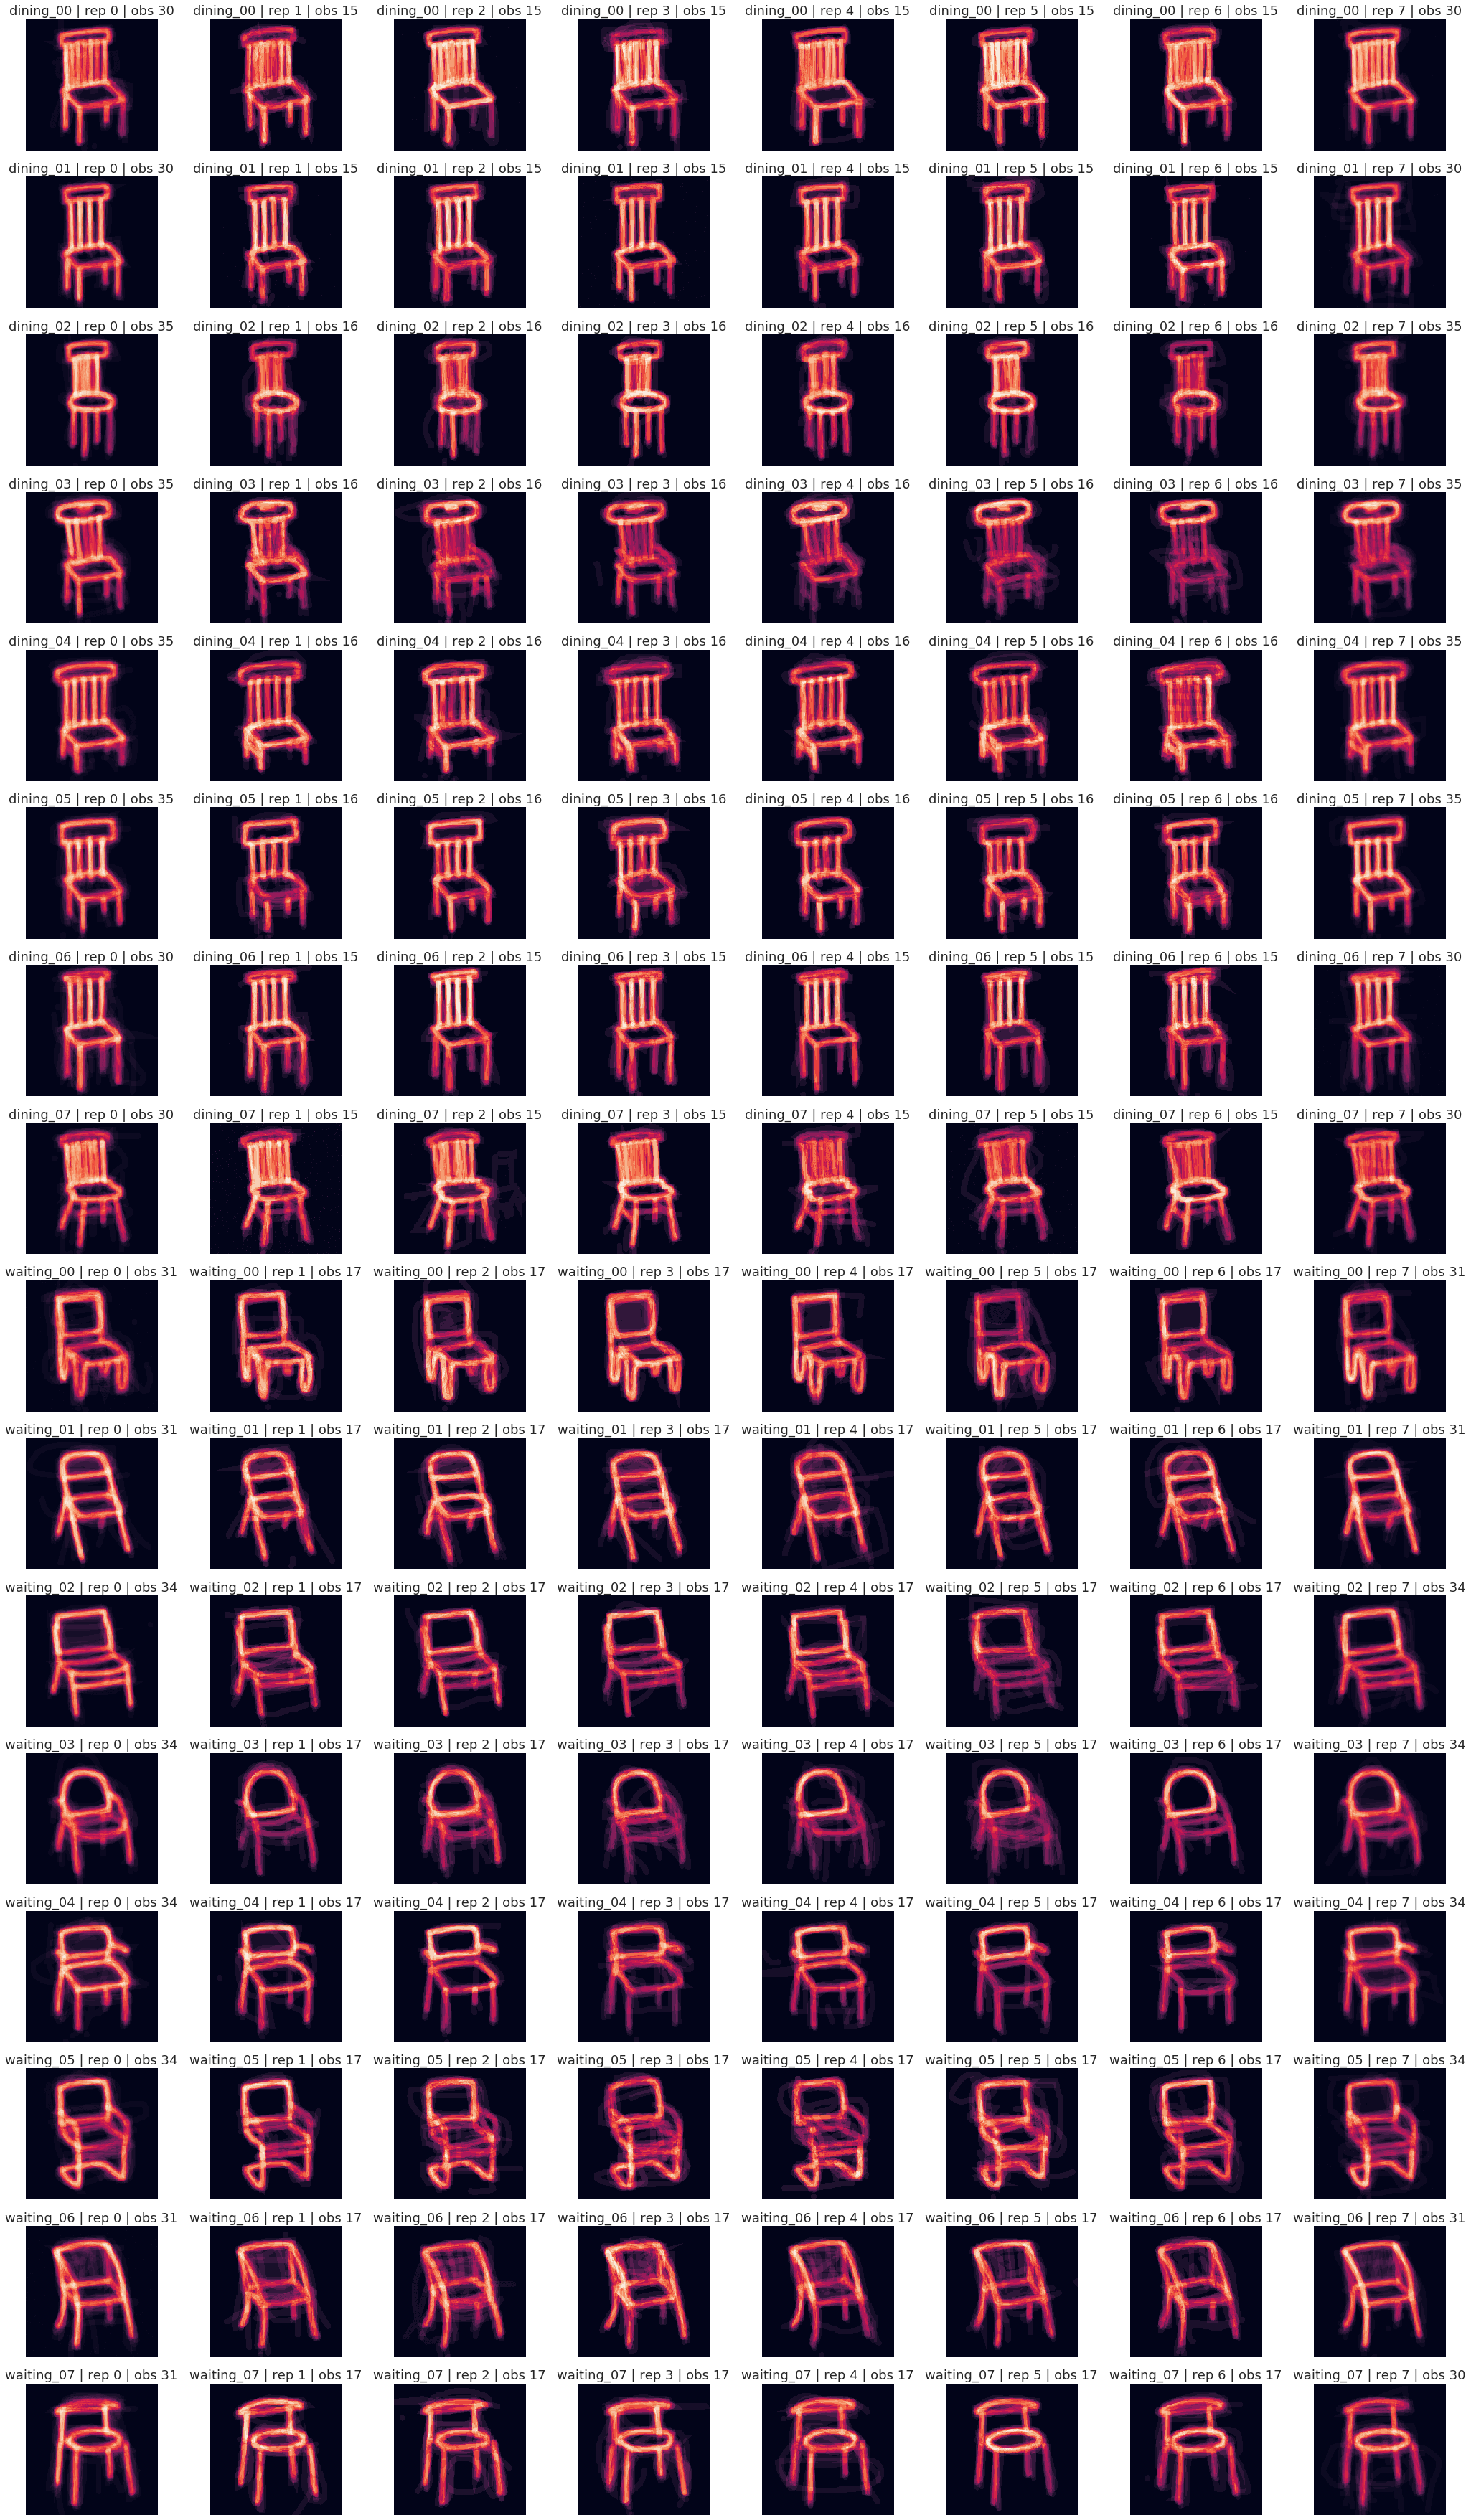

In [74]:
## render heat map gallery
importlib.reload(u)
with open(os.path.join(map_dir,'targetRep_map_meta.js')) as f:
    G = json.load(f)
u.render_heatmap_gallery(G, gallery_dir = gallery_dir, 
                         data_dir = '/home/jefan/semantic_mapping/results/maps/targetRep_sketch_maps',
                         num_reps = 8, 
                         show_fig = True)

### check how many sketches we have annotated so far, how many times

In [101]:
path_to_meta = os.path.join(stimuli_dir,'graphical_conventions_group_data_run5_submitButton.csv')
M = pd.read_csv(path_to_meta)
M['filename'] = M.apply(lambda x: '{}_{}_{}'.format(x['gameID'],  x['target'], str(x['repetition']).zfill(2)), axis=1)

In [102]:
all_sketches = sorted(list(M['filename']))
annotated_sketches = [i.split('.')[0] for i in sorted(os.listdir(single_sketch_map_dir))]

In [103]:
num_remaining = len([i for i in all_sketches if i not in annotated_sketches])
print('We have already annotated {} sketches.'.format(len(annotated_sketches)))
print('We have {} sketches remaining to annotate out of {} total sketches.'.format(num_remaining, len(all_sketches)))

We have already annotated 2599 sketches.
We have 1 sketches remaining to annotate out of 2600 total sketches.


In [104]:
## save out list of annotated sketches
N = pd.DataFrame(annotated_sketches)
N.columns = ['sketch_id']
N.to_csv(os.path.join(csv_dir,'stroke_mapping_annotated_sketches.csv'),index=False)

In [105]:
len(annotated_sketches)

2599

In [106]:
[i for i in all_sketches if i not in annotated_sketches]

['7741-1061961c-2778-483e-97de-15fc47b71ca5_waiting_07_07']